<h1>Classes of Signals</h1>

In [1]:
radio_class = open("gcs/classes.txt")
print(radio_class.read())

radio_class.close()

classes = ['32PSK',
 '16APSK',
 '32QAM',
 'FM',
 'GMSK',
 '32APSK',
 'OQPSK',
 '8ASK',
 'BPSK',
 '8PSK',
 'AM-SSB-SC',
 '4ASK',
 '16PSK',
 '64APSK',
 '128QAM',
 '128APSK',
 'AM-DSB-SC',
 'AM-SSB-WC',
 '64QAM',
 'QPSK',
 '256QAM',
 'AM-DSB-WC',
 'OOK',
 '16QAM']


<h1> Importing Deep Learning Libraries </h1>

In [2]:
import zipfile
# from google.colab import files
import os
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import numpy as np
import keras
from keras import layers
from tensorflow.keras.utils import to_categorical
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.layers import Input, Dropout, Add, Dense, Reshape, Activation
from keras.layers import BatchNormalization, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam

<h1>Data Visualization</h1>

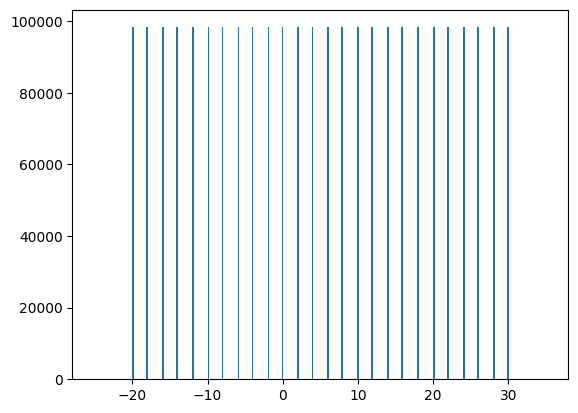

In [11]:
data = np.load('gcs/snrs.npy')
plt.hist(data.ravel(),256,[-25,35])
plt.show()

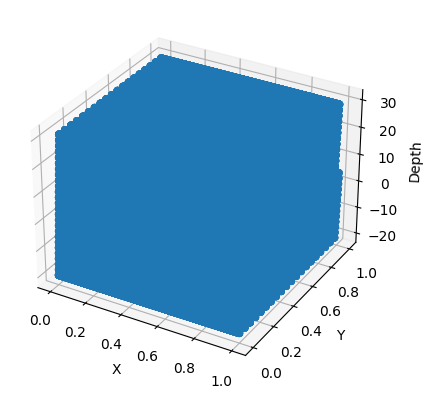

In [4]:
img_array = np.load('gcs/snrs.npy')
img_array.resize(1080,1920)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(0,1,1920)
y = np.linspace(0,1,1080)
z = img_array
x, y = np.meshgrid(x, y)
ax.scatter(x, y, z)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Depth');

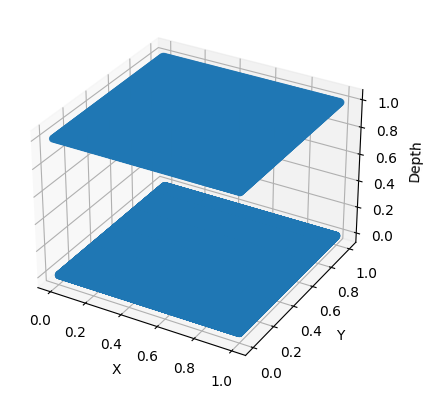

In [5]:
img_array = np.load('gcs/labels.npy')
img_array.resize(720,1280)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(0,1,1280)
y = np.linspace(0,1,720)
z = img_array
x, y = np.meshgrid(x, y)
ax.scatter(x, y, z)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Depth');

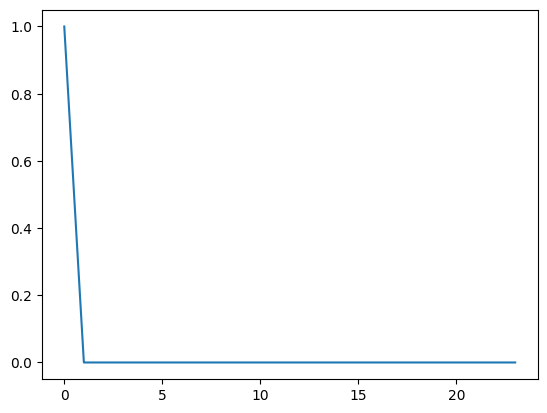

In [14]:
data = np.load('gcs/labels.npy')
plt.plot(data[0])
plt.show()

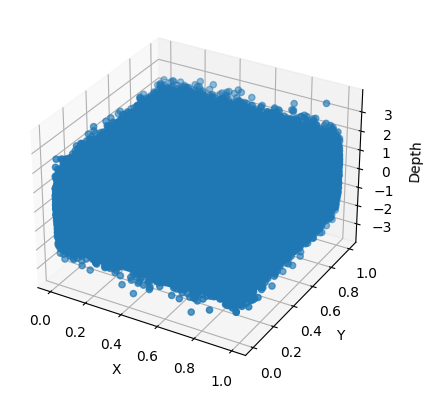

In [9]:
img_array = np.load('gcs/signals.npy')
img_array.resize(1080,1920)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(0,1,1920)
y = np.linspace(0,1,1080)
z = img_array
x, y = np.meshgrid(x, y)
ax.scatter(x, y, z)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Depth');

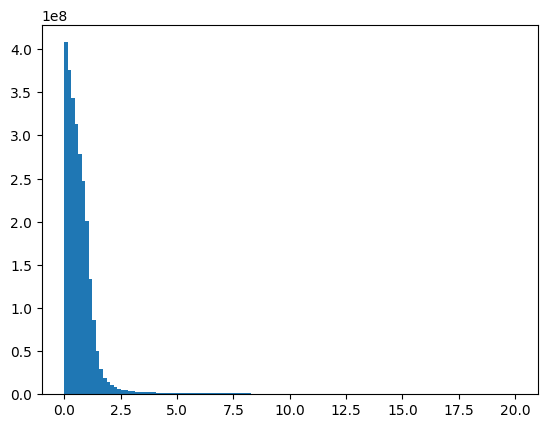

In [19]:
data = np.load('gcs/signals.npy')
plt.hist(data.ravel(),128,[0,20])
plt.show()

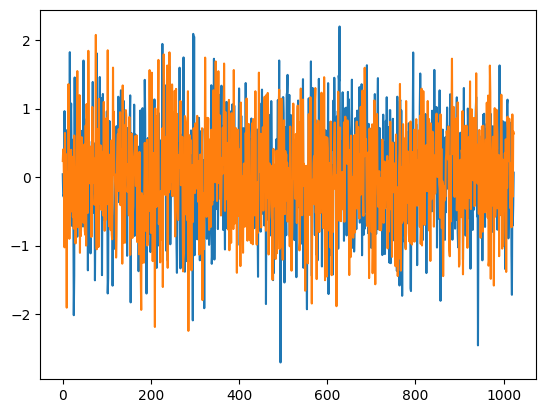

In [10]:
data = np.load('gcs/signals.npy')
plt.plot(data[0])
plt.show()

<h1>Getting and Loading the Data</h1>

In [15]:
# Upload signals, labels, snrs
labels = np.load('gcs/labels.npy', mmap_mode = 'r')
signals = np.load('gcs/signals.npy', mmap_mode = 'r')
snrs = np.load('gcs/snrs.npy', mmap_mode = 'r')

In [16]:
# Split arrays for two 2 parts (we take only second part of dataset of labeled signals because of the memory)
part = 2
signals = signals[::part, :, :] # 3D array
labels = labels[::part, :] # 2D array
snrs = snrs[::part, :] # 2D array

print(signals.shape)
print(labels.shape)
print(snrs.shape)

(1277952, 1024, 2)
(1277952, 24)
(1277952, 1)


In [17]:
# Ndarray to array
snrs = np.ravel(snrs)
print(f"All possible SNRS: {np.unique(snrs)} db") # f string, return unique snrs

All possible SNRS: [-20. -18. -16. -14. -12. -10.  -8.  -6.  -4.  -2.   0.   2.   4.   6.
   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.  30.] db


In [18]:
# Masked numpy array 
c = np.ma.masked_where(snrs > 8, snrs)
print(c)
msk = c.mask
# Count unique elements in array
print(np.unique(c.mask, return_counts=True))

[-20.0 -20.0 -20.0 ... -- -- --]
(array([False,  True]), array([737280, 540672]))


In [19]:
# Mask array of signals and labels (snrs > 8)
signals = signals[msk]
labels = labels[msk]

print(len(signals))
print(len(labels))

540672
540672


In [20]:
# Train|test = 80|20

x_train,x_test, y_train, y_test = train_test_split(signals, labels, train_size=0.8, stratify=labels)

# print(f"Number of rows in y_train by class: {np.bincount(y_train)}")
# print(f"Number of rows in y_test by class: {np.bincount(y_test)}")
print(x_test.shape)
print(y_test.shape)

# Train|validation|test = 64|16|20
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, stratify=y_train)

# Validation is done for Model Hyperparameter Tuning, we share data from training to validation for this purpose

# print(f"Number of rows in y_train by class: {np.bincount(y_test)}")
# print(f"Number of rows in y_test by class: {np.bincount(y_val)}")
print(x_train.shape)
print(y_train.shape)

(108135, 1024, 2)
(108135, 24)
(346029, 1024, 2)
(346029, 24)


<h1>Creating Residual Block</h1>

In [21]:
# Create residual and convolution block
class Residual_block:
    kernel_size = 3
    strides = 1
    padding = 'same'
    data_format = "channels_last"

    def __init__(self, x, x_shortcut, filters):
        self.x = x
        self.filters = filters
        self.x_shortcut = x_shortcut

    def unit(self):
        x = Conv1D(self.filters, self.kernel_size, self.strides, self.padding, self.data_format)(self.x)
        x = Activation('relu')(x)
        x = Conv1D(self.filters, self.kernel_size, self.strides, self.padding, self.data_format)(x)
        x = Activation('linear')(x)
        # add skip connection
        if x.shape[1:] == self.x_shortcut.shape[1:]:
            x = Add()([x, self.x_shortcut])
        else:
            raise Exception('Skip Connection Failure!')
        return x

class Convolution_block:
    kernel_size = 1
    strides = 1
    padding = 'same'
    data_format = "channels_last"

    def __init__(self, x, filters):
        self.x = x
        self.filters = filters

    def unit(self):
        x = Conv1D(self.filters, self.kernel_size, self.strides, self.padding, self.data_format)(self.x)
        x = Activation('linear')(x)
        return x

<h1> Creating Residual Stack </h1>

In [22]:
# Create residual stack
def residual_stack(x, filters):
    x = Convolution_block(x, filters)
    print('x')
#     print(x.shape)
    print(x)
    x = x.unit()
    print('xunit')
#     print(x.shape)
    print(x)
    
    x_shortcut = x
    x = Residual_block(x, x_shortcut, filters)
    x = x.unit()
    x_shortcut = x
    x = Residual_block(x, x_shortcut, filters)  
    x = x.unit()
    
    # max pooling layer
    x = MaxPooling1D(pool_size=2, strides=None, padding='valid', data_format='channels_last')(x)
#     print('Residual stack created')
    return x

<h1> Defining ResNet Model </h1>

In [23]:
# define resnet model
def ResNet(input_shape, classes):   
    # create input tensor
    x_input = Input(input_shape)
    x = x_input
    # residual stack
    num_filters = 40
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    
    # output layer
    x = Flatten()(x)
    x = Dense(128, activation="selu", kernel_initializer="he_normal")(x)
    x = Dropout(.5)(x)
    x = Dense(128, activation="selu", kernel_initializer="he_normal")(x)
    x = Dropout(.5)(x)
    x = Dense(classes , activation='softmax', kernel_initializer = glorot_uniform(seed=0))(x)
    
    # Create model
    model = Model(inputs = x_input, outputs = x)
#     print('Model ResNet created')
    return model

<h1> Save Model Weights and History </h1>

In [24]:
# option to save model weights and model history
save_model = True
save_history = True

# create directory for model weights
if save_model is True:
    weights_path = input("Name model weights directory: ")
    weights_path = "data/weights/" + weights_path

    try:
        os.mkdir(weights_path)
    except OSError:
        print ("Creation of the directory %s failed" % weights_path)
    else:
        print ("Successfully created the directory %s " % weights_path)
    print('\n')
    

# create directory for model history
if save_history is True:
    history_path = input("Name model history directory: ")
    history_path = "data/model_history/" + history_path

    try:
        os.mkdir(history_path)
    except OSError:
        print ("Creation of the directory %s failed" % history_path)
    else:
        print ("Successfully created the directory %s " % history_path)
    print('\n')

Name model weights directory:  model_weights


Successfully created the directory data/weights/model_weights 




Name model history directory:  history_


Successfully created the directory data/model_history/history_ 




<h1> Set Model Parameters </h1>

In [25]:
# initialize optimizer 
adm = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# set number of epochs
num_epochs = int(input('Enter number of epochs: '))

# set batch size
batch = 32

# configure weights save

if save_model is True:
    filepath= weights_path + "/{epoch}.hdf5"
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode="auto")
    callbacks_list = [checkpoint]
else:
    callbacks_list = []

Enter number of epochs:  30


<h1> Print Model Summary and Train Network </h1>

In [27]:
# initialize and train model
model = ResNet((1024, 2), 24)
model.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(x_train, y_train, epochs = num_epochs, batch_size = batch, callbacks=callbacks_list, validation_data=(x_val, y_val))

x
xunit
KerasTensor(type_spec=TensorSpec(shape=(None, 1024, 40), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'activation_25'")
x
xunit
KerasTensor(type_spec=TensorSpec(shape=(None, 512, 40), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'activation_30'")
x
xunit
KerasTensor(type_spec=TensorSpec(shape=(None, 256, 40), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'activation_35'")
x
xunit
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 40), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'activation_40'")
x
xunit
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 40), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'activation_45'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #    

<h1> Save Model History </h1>

In [28]:
# record model history
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

if save_history is True:
    # save model history: loss and accuracy
    np.save(history_path + 'train_acc.npy', train_accuracy)
    np.save(history_path + 'train_loss.npy', train_loss)
    np.save(history_path + 'val_acc.npy', val_accuracy)
    np.save(history_path + 'val_loss.npy', val_loss)
    print("Model History Saved!")
    print('\n')

Model History Saved!




<h1> Model Training Accuracy </h1>

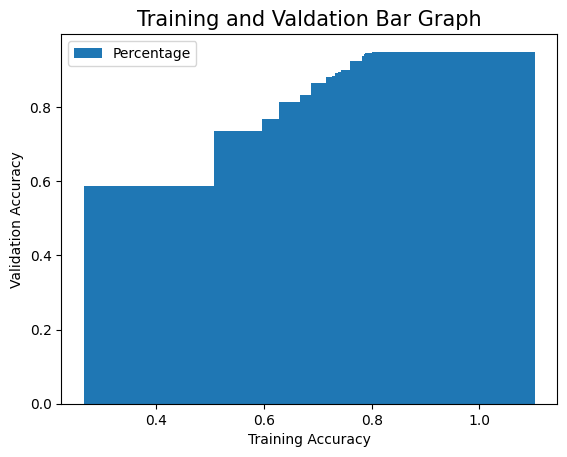

In [31]:
x = train_accuracy
y= val_accuracy

plt.xlabel("Training Accuracy",fontsize=10)
plt.ylabel("Validation Accuracy",fontsize=10)
plt.title("Training and Valdation Bar Graph",fontsize=15)

plt.bar(x,y,width=0.3,align='center',label='Percentage')
plt.legend()

plt.show()

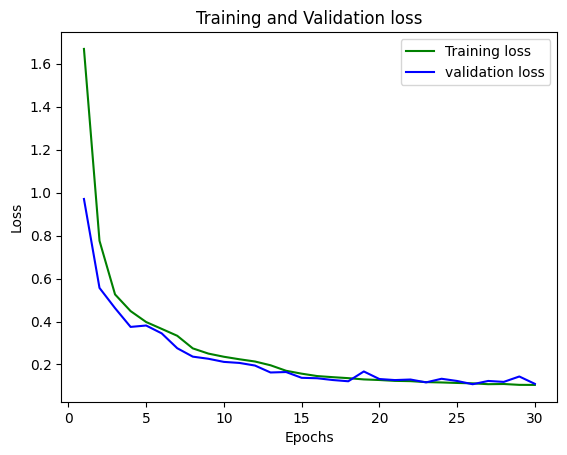

In [33]:
loss_train = train_loss
loss_val = val_loss
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

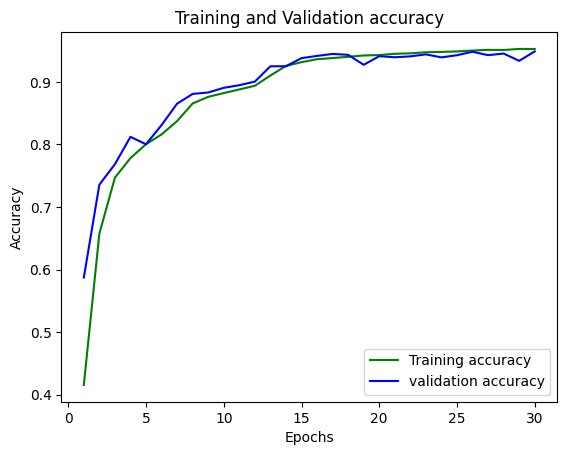

In [34]:
acc_train = train_accuracy
acc_val = val_accuracy
epochs = range(1,31)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<h1>  Evaluating Model Performace: on Test Data </h1>

In [40]:
# evaluate model on test data
loss, acc = model.evaluate(x_test, y_test, batch_size=32)
print('EVALUATING MODEL ON TEST DATA:')
print('Test Accuracy: ', str(round(acc*100, 2)), '%') # calculated by compairing real o/p with the model prediction
print('\n')

3380/3380 [==============================] - 19s 6ms/step - loss: 0.1072 - accuracy: 0.9502
EVALUATING MODEL ON TEST DATA:
Test Accuracy:  95.02 %


